# FashionMNIST and VAE

FashionMNIST is a simple dataset used for benchmarking machine learning algorithms. It serves as a direct alternative to the classic MNIST dataset, providing a slightly more challenging task while maintaining a similar structure. Instead of handwritten digits, FashionMNIST consists of grayscale images depicting various clothing items and accessories.

The FashionMNIST dataset contains a total of 70,000 images, split into 60,000 training examples and 10,000 test examples. Each image is a 28x28-pixel grayscale image, representing one of the following 10 classes:

1. T-shirt/top
2. Trouser
3. Pullover
4. Dress
5. Coat
6. Sandal
7. Shirt
8. Sneaker
9. Bag
10. Ankle boot

The dataset aims to provide a more realistic and diverse set of images compared to MNIST, making it suitable for testing the robustness and generalization ability of machine learning models.


---

**Homework Assignment: FashionMNIST and Variational Autoencoders (VAEs)**

**Objective:**
To familiarize yourself with the FashionMNIST dataset and explore the application of variational autoencoders (VAEs) in generative modeling and unsupervised learning tasks.

## Task 1 : Train a VAE on the FashionMNIST dataset and visulize the latent space using the techniques we explained in class.




100%|██████████| 26421880/26421880 [00:02<00:00, 11162117.38it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202657.05it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3633845.91it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16921847.17it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



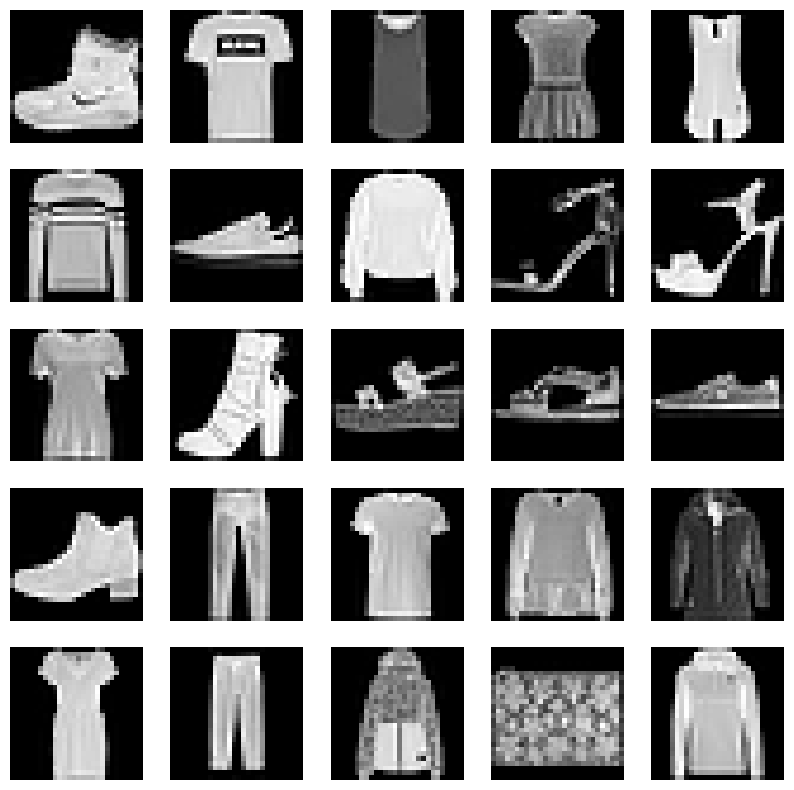

In [1]:
import torchvision
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt

# Load FashionMNIST dataset
train_dataset = FashionMNIST(root="./data", train=True, download=True, transform=torchvision.transforms.ToTensor())

# Plot sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_dataset[i][0].squeeze().numpy(), cmap='gray')
    plt.axis('off')
plt.show()


## Task 2 : experiment with Conditional Variational Autoencoder


Conditional Variational Autoencoder (CVAE) is an extension of the Variational Autoencoder (VAE) that allows for conditional generation of data. In standard VAE, the latent space captures the underlying structure of the entire dataset. However, in many real-world scenarios, we may want to generate data conditioned on some specific attributes or labels. CVAE addresses this by incorporating conditional information into both the encoding and decoding processes.

In a CVAE, the encoder not only takes the input data but also takes in conditional information, such as class labels. This conditional information is then incorporated into the latent representation. Similarly, during decoding, the decoder takes both the latent representation and the conditional information to generate the output.

CVAEs have various applications, including image generation, text generation, and more. For example, in image generation tasks, CVAEs can generate images of different classes based on the provided class labels.

Questions:

1. How does a Conditional Variational Autoencoder (CVAE) differ from a standard Variational Autoencoder (VAE)?
2. What is the purpose of incorporating conditional information in a CVAE?
3. In the provided code, how is the FashionMNIST dataset conditioned during training?
4. Explain the role of the Encoder and Decoder in a Conditional Variational Autoencoder.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt

# Define VAE architecture with class conditioning
class Encoder(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_class = nn.Linear(num_classes, latent_dim)

    def forward(self, x, y):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        class_embedding = self.fc_class(y)  # No need to convert to float
        z = mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)
        z += class_embedding
        return mu, logvar, z

class Decoder(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim + num_classes, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)

    def forward(self, z, y):
        z = torch.cat((z, y), dim=1)
        x = self.fc(z)
        x = x.view(x.size(0), 64, 7, 7)
        x = torch.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim, num_classes)
        self.decoder = Decoder(latent_dim, num_classes)

    def forward(self, x, y):
        mu, logvar, z = self.encoder(x, y)
        recon_x = self.decoder(z, y)
        return recon_x, mu, logvar

# Define VAE loss function
def vae_loss(recon_x, x, mu, logvar, criterion):
    BCE = criterion(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Define training loop with class conditioning
def train_vae(vae, train_loader, optimizer, criterion, device, epochs):
    vae.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)  # Move data to device
            data = (data - torch.min(data)) / (torch.max(data) - torch.min(data))  # Normalize data to range [0, 1]
            labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)  # Convert labels to one-hot encoding
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data, labels_one_hot)
            loss = vae_loss(recon_batch, data, mu, logvar, criterion)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}")


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 20
num_classes = 10  # Number of classes in FashionMNIST dataset
batch_size = 128
epochs = 15
learning_rate = 1e-3

# Load and preprocess FashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize VAE model, optimizer, and loss criterion
vae = VAE(latent_dim, num_classes).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')

# Train VAE with class conditioning
train_vae(vae, train_loader, optimizer, criterion, device, epochs)



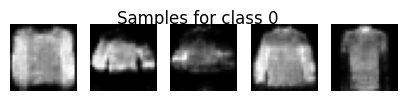

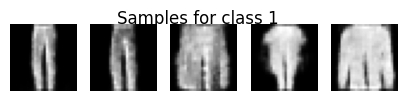

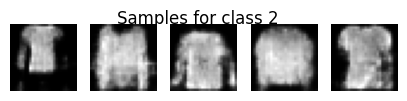

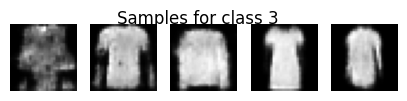

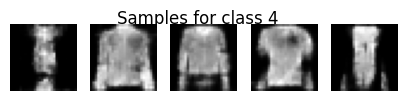

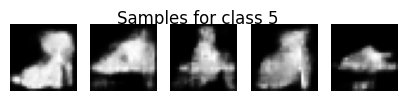

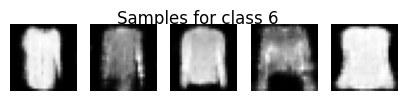

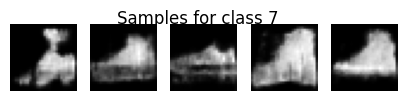

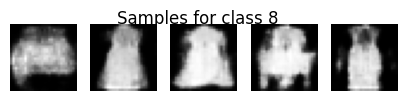

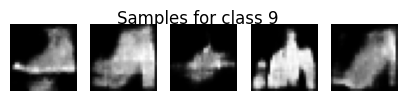

In [29]:
# Generate samples according to the original class
def generate_samples(vae, num_samples_per_class):
    vae.eval()
    with torch.no_grad():
        for i in range(num_classes):
            class_label = torch.tensor([i]).to(device)
            z = torch.randn(num_samples_per_class, latent_dim).to(device)
            y = torch.zeros(num_samples_per_class, num_classes).to(device)  # Initialize y as one-hot encoded vector
            y[:, i] = 1  # Set the element corresponding to the class label to 1
            samples = vae.decoder(z, y)
            samples = (samples * 0.5) + 0.5  # De-normalize samples to range [0, 1]
            samples = samples.view(-1, 28, 28).cpu().numpy()

            plt.figure(figsize=(num_samples_per_class, 1))
            for j in range(num_samples_per_class):
                plt.subplot(1, num_samples_per_class, j + 1)
                plt.imshow(samples[j], cmap='gray')
                plt.axis('off')
            plt.suptitle(f'Samples for class {i}')
            plt.show()

# Generate and visualize samples for each class
num_samples_per_class = 5
generate_samples(vae, num_samples_per_class)
